## Inverse Gaussian distribution
The inverse gaussian $\mathcal{\mu, \lambda}$ has an explicit density

$p(x) = \sqrt{\frac{\lambda}{2 \pi x^3}} e^{-\frac{\lambda (x-\mu)^2}{2 \mu^2 x}} \mathcal{I}_{x > 0}$

Its subordinator $Y_t$ has distribution $Y_t | Y_0 \tilde{} \mathcal{IG}(t, \frac{t^2}{\kappa})$ where $\kappa$ is the variance at $t=1$.

The normal inverse Gaussian process can be represented as

$Z_t = \theta Y_t +\sigma W_{Y_t}$

where $W$ is a standard Brownian motion and $Y$ is an inverse Gaussian subordinator. It has a distribution $Z_t | Z_0 \tilde{} \mathcal{N}(\theta Y_t, \sigma^2 Y_t)$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

C:\Users\surface\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\surface\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
C:\Users\surface\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
def inverse_gaussian(mu, l):
    N = np.random.normal()
    U = np.random.uniform()
    Y = N**2
    X1 = mu + mu**2*Y/2/l - mu/(2*l)*np.sqrt(4*mu*l*Y + mu**2*Y**2)
    
    if U>mu/(X1+mu):
        return mu**2/X1
    else:
        return X1

In [3]:
def normal_inverse_gaussian(N, T, k, sigma, theta, x0 = 0):
    x_ns = np.zeros(N)
    t_ns = np.zeros(N)
    
    dt = T/N
    x = x0
    for n in range(N):
        N_n = np.random.normal()
        dS_n = inverse_gaussian(mu = dt, l = dt**2/k)
        dX_n = sigma*N_n*np.sqrt(dS_n) + theta*dS_n
        
        x_n = x+dX_n
        x_ns[n] = x_n
        t_ns[n] = n*dt
        
        x=x_n
    
    if N == 1:
        return x_ns[0]
    else:
        return x_ns, t_ns
        

In [4]:
def f_episilon(x, alpha, episilon, kappa):
    if x<episilon:
        return 0
    else:
        return alpha*episilon**(alpha)/(x**(alpha+1))*(1/np.sqrt(2*np.pi*kappa))
def ro(x, kappa):
    return np.exp(-x/2/kappa)/(np.sqrt(2*np.pi*kappa)*x**1.5)

def normal_IG_by_CP(N, episilon, T, l, kappa, theta, sigma):
    # Return N jump sizes and N jump times
    # l: lambda, jump intensity (jump size > episilon), 
    # episilon: minimum jump size considered, 
    # kappa: variance of IG process at T = 1
    
    # N = np.random.poisson(l*T) # number of jumps
    U_N = np.random.uniform(high = T, size = N) # N times of jumps
    Y_N = np.zeros(N)
    
    for n in range(N):
        # nth jump size
        V = 2.0
        T = 1.0
        B = np.random.uniform()

        while V*T>1:
            W = np.random.uniform()
            V = np.random.uniform()
            X = episilon*W**(-1/0.5)
                  
            denominator = 0.5*ro(X, kappa)
            
            if X < episilon or denominator == 0.0:
                V = 2.0
                T = 1.0
                continue
            else:  
                try:
                    T = f_episilon(X, 1/2, episilon, kappa)*episilon**(-1/2)*np.exp(-episilon/(2*kappa))/denominator
                except:
                    V = 2.0
                    T = 1.0
                    continue
        
        W_y = np.random.normal(0,X)
        Y_N[n] = theta*X + sigma*W_y
    
    return Y_N, U_N

In [153]:
len(U_N)

101

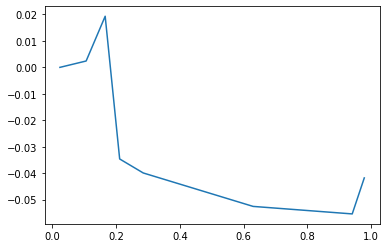

In [8]:
def trajectory_normal_IG_by_CP(N, episilon, T, l_e, kappa, theta, sigma):
    Y_N, U_N = normal_IG_by_CP(N, episilon, T, l_e, kappa, theta, sigma)
    t_ns = sorted(U_N)
    x_ns = np.zeros(N)
    for i in range(len(U_N)):
        t = t_ns[i]
        x_ns[i] = sum([y for y,u in zip(Y_N,U_N) if u<t])
    return t_ns, x_ns

t_ns, x_ns = trajectory_normal_IG_by_CP(N, episilon, T, l_e, kappa, theta, sigma)
plt.plot(t_ns, x_ns)

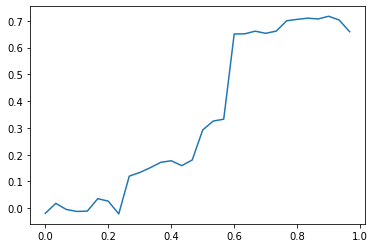

In [203]:
x_ns, t_ns = normal_inverse_gaussian(N = N, T = 1, k = 0.6, sigma = 0.5, theta = 0.4)

plt.plot(t_ns, x_ns)

## Estimate expectation
Consider 1D SDE

$dX_t = \sin (a X_t) dZ_t$

The solution of the corresponding deterministic ODE

$dX_t = \sin (a X_t) dt,$ $X_0 = x$

is given explicitly by

$X_t = \theta(t;x) = \frac{1}{a} \arccos \frac{1+\cos (ax) -e^{2at}(1-\cos(ax))}{1+cos(ax)+e^{2at}(1-\cos(ax))}$

We want to compute the Monte Carlo estimator of $\mathbb{E}[f(X_1)]$ with

$f(x) = 2-2 \cos(x-X_0)$
### Euler
First we compute it by Euler

In [6]:
def theta_x_t(x, t, a):
    numerator = 1+np.cos(a*x)-np.exp(2*a*t)*(1-np.cos(a*x))
    denominator = 1+np.cos(a*x)+np.exp(2*a*t)*(1-np.cos(a*x))
    
#     return 2*np.pi/a - np.arccos(numerator/denominator)/a
    
    # deal with periodicity
    n = int(a*x//np.pi)

    if n%2 == 0:
        return np.arccos(numerator/denominator)/a+n*np.pi/a
    else:
        return (n+1)*np.pi/a - np.arccos(numerator/denominator)/a

def h(x, a):
    return np.sin(a*x)
def h_dash(x, a):
    return a*np.cos(a*x)

In [5]:
# compute useful constants
kappa = 0.6
theta = 0.4
sigma = 0.5
T = 1
a = 5

episilon = 1e-2
l_e = np.sqrt(2/(np.pi*kappa*episilon))*np.exp(-episilon/(2*kappa), dtype = np.float64)-2/kappa*norm.cdf(-np.sqrt(episilon/kappa))
r_e = theta - 2*theta*norm.cdf(-np.sqrt(episilon/kappa))
sigma_e2 = (sigma**2+kappa*theta**2)*(1-2*norm.cdf(-np.sqrt(episilon/kappa, dtype = np.float64)))\
            -theta**2*np.sqrt(2*kappa*episilon, dtype = np.float64)/np.sqrt(np.pi)*np.exp(-episilon/(2*kappa), dtype = np.float64)
sigma_e = np.sqrt(sigma_e2)

N = int(l_e) # discretization point = number of jumps

In [439]:
N

8

0.18440911672147287


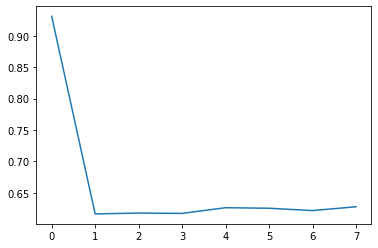

In [444]:
# Estimate expectation using monte carlo
M = int(1e5) # number of trajectory
sum_M = 0

for m in range(M):
    z_ns, _ = normal_inverse_gaussian(N = N, T = 1, k = 0.6, sigma = 0.5, theta = 0.4)
#     z_ns, _ = trajectory_normal_IG_by_CP(N, episilon, T, l_e, kappa, theta, sigma)
    z = 0
    x0 = 1
    x = 1
    
    x_ns = []
    for n in range(N):
        z_n = z_ns[n]
        dz = z_n - z
        
        z = z_n
        
        dx = np.sin(a*x)*dz
        x += dx
        x_ns.append(x)
    
    fx = 2*(1-np.cos(x-x0))
    sum_M += fx
    
exp = sum_M/M
print(exp)
plt.plot(x_ns)

Now we compute using section 3 method

In [47]:
import warnings
warnings.simplefilter('error') # prevent overflow/divide by zero warning

0.1534283531768497


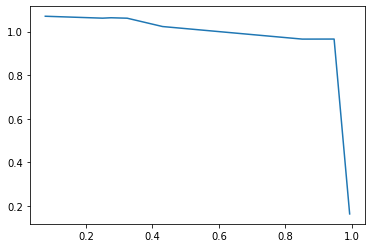

In [443]:
M = int(1e5)
sum_M = 0
for m in range(M):
    # find all jump sizes and jump times
    Y_N, U_N = normal_IG_by_CP(N, episilon, T, l_e, kappa, theta, sigma)
    # sort u and y according to time
    Y_N = [y for y, u in sorted(zip(Y_N, U_N), key=lambda pair: pair[1])]
    U_N.sort()
    
    t_ns = []
    x_ns = []
    x_minus_ns = []
    
    x0=1
    u0=0

    for u, y in zip(U_N, Y_N):
        # brownian motion between u_n and u_(n+1)
        du = u-u0
        dW = np.random.normal(0,du)
        t = r_e*du+sigma_e*dW-0.5*h_dash(x0,a)*sigma_e**2*du
        
        x_n_minus =theta_x_t(x0, t, a)
        x_n = x_n_minus + h(x_n_minus, a)*y
#         x_n = x0 + h(x0, a)*y
#         x_n_minus = theta_x_t(x_n, t, a) 
        
        x_minus_ns.append(x_n_minus)
        x_ns.append(x_n)
        t_ns.append(u)
        
        # reset x for next iteration
        x0 = x_n
        u0 = u

    fx = 2*(1-np.cos(x_n-1))
    sum_M+=fx
    
exp = sum_M/M
print(exp)
#plt.plot(t_ns,x_minus_ns)
plt.plot(t_ns, x_ns)
